In [1]:
############################# Import Section #################################

## Imports related to PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import transforms, utils
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn.functional as F

## Generic imports
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import classification_report
from copy import deepcopy
import math
import random
from tqdm import tqdm

## Dependencies classes and functions
from utils import gridRing
from utils import asMinutes
from utils import timeSince
from utils import getWeights
from utils import save_checkpoint
from utils import getListOfFolders

## Import Model
from DyanOF import OFModel,creatRealDictionary,fista

############################# Import Section #################################

C:\Users\lpott\anaconda3\envs\DYAN\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(df,chunk_size=1):
    X = []
    for i in tqdm(df.index.unique()):
        x = torch.FloatTensor(df.loc[i].values)
        size = x.shape[0]
        if chunk_size > 1:
            size = int(size/chunk_size)
        x = torch.chunk(x,chunk_size)
        X.extend(x)
    X = torch.stack(X, 0)
    return X

def load_dataset(dataset_name = "lorenz",file_path=r'C:\Users\lpott\Desktop\DYAN\Code\data',chunk_size=1):

    with open(os.path.join(file_path,f"{dataset_name}/{dataset_name}_train_inputs.pickle"), "rb") as handle:
        train_df = pickle.load(handle)

    with open(os.path.join(file_path,f"{dataset_name}/{dataset_name}_test_inputs.pickle"), "rb") as handle:
        test_df = pickle.load(handle)

    X_train = load_data(train_df,chunk_size)
    X_test = load_data(test_df,chunk_size)

    return X_train,X_test

In [3]:
class differential_dataset(Dataset):

    def __init__(self,X,horizon):

        self.X = X
        self.horizon = horizon
        self.D = X.shape[-1]
        self.T = X.shape[1]-self.horizon+1
        
        print(self.horizon)
        print(self.T)
        self.mu = torch.mean(X,dim=[0,1])#torch.tensor([torch.mean(X[:,:,0]), torch.mean(X[:,:,1]), torch.mean(X[:,:,2])])
        self.std = torch.std(X,dim=[0,1])#torch.tensor([torch.std(X[:,:,0]), torch.std(X[:,:,1]), torch.std(X[:,:,2])])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self,idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        if type(idx) is int:
            idx = [idx]

        
        start = torch.randint(low=0,high=self.T,size=(len(idx),))
        windows = torch.tensor([list(range(i,i+self.horizon)) for i in start]).unsqueeze(-1).repeat(1,1,self.D)
        x = torch.gather(self.X[idx],1,windows).squeeze()

        return x

In [4]:
class differential_dataset_strided(Dataset):

    def __init__(self,X,horizon,stride):

        self.X = X
        self.horizon = horizon
        self.D = X.shape[-1]
        self.T = X.shape[1]-self.horizon+1
        self.stride = stride
        print(self.horizon)
        print(self.T)

        self.X = torch.concat([X[:,i:(i+horizon),:] for i in range(0,self.T,stride)],0)
        
#         self.mu = torch.mean(X,dim=[0,1])#torch.tensor([torch.mean(X[:,:,0]), torch.mean(X[:,:,1]), torch.mean(X[:,:,2])])
#         self.std = torch.std(X,dim=[0,1])#torch.tensor([torch.std(X[:,:,0]), torch.std(X[:,:,1]), torch.std(X[:,:,2])])
        print(X.shape)
        self.mu = torch.tensor([torch.mean(X[:,:,i]) for i in range(self.D)])
        self.std = torch.tensor([torch.std(X[:,:,i]) for i in range(self.D)])        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self,idx):

#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         if type(idx) is int:
#             idx = [idx]

        x = self.X[idx,:,:]
        
        return x

In [5]:
class encoder(nn.Module):
    def __init__(self,D,hidden_dim,latent_dim,dropout=0,layer_norm_epsilon=1e-5,device='cuda:0'):
        super(encoder,self).__init__()
        self.D = D
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device
        self.dropout = dropout
        
        self.Encoder =  nn.Sequential(
            nn.Linear(D, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.LayerNorm(latent_dim, eps=layer_norm_epsilon,elementwise_affine=False),
            nn.Dropout(dropout)
        )
        
        self.init_weight()
        
    def forward(self,x):
#         
        x = self.Encoder(x)
        
        return x
    
    def init_weight(self):
        def initialize_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
        self.Encoder.apply(initialize_weights)

In [6]:
class decoder(nn.Module):
    def __init__(self,D,hidden_dim,latent_dim,device='cuda:0'):
        super(decoder,self).__init__()
        self.D = D
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device
        
        self.Decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, D)
        )
        
        self.init_weight()

    def forward(self,x):
        
        x = self.Decoder(x)
        
        return x
    
    def init_weight(self):
        def initialize_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
        self.Decoder.apply(initialize_weights)

In [39]:
class TDYANT(nn.Module):
    def __init__(self, 
                 Drr, 
                 Dtheta,
                 N,
                 D,
                 hidden_dim,
                 latent_dim,
                 dropout=0,
                 layer_norm_epsilon=1e-5,
                 device='cuda:0'):
        
        super(TDYANT, self).__init__()
        
        self.rr = nn.Parameter(Drr)
        self.theta = nn.Parameter(Dtheta)
        self.device = device
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder_ = encoder(D,hidden_dim,latent_dim,dropout,layer_norm_epsilon,device)
        self.decoder_ = decoder(D,hidden_dim,latent_dim,device)
        
        self.register_buffer('mu', torch.zeros((D,)))
        self.register_buffer('std', torch.ones((D,)))
        
    def forward(self, x,horizon):
        x = self._normalize(x)
        
        x_recon,x_ahead = x[:,:horizon,:],x[:,horizon:,:]
        print(x_recon.shape)
        print(x_ahead.shape)
        T = x_recon.shape[1]
        T_Total = x_recon.shape[1] + x_ahead.shape[1]

        
        latent = self.encoder_(x_recon)

        dic = creatRealDictionary(T_Total,self.rr,self.theta,device=self.device)
        dic_recon = dic[:horizon]
#         dic_ahead = dic[horizon:]
        
        ## for UCF Dataset:
        # 0.1
        sparsecode = fista(dic_recon,latent,0.01,100,self.device)

        y = torch.matmul(dic,sparsecode)
        y_recon = y[:,:horizon,:]
        y_ahead = y[:,horizon:,:]

        x_recon_all = self.decoder_(y)
        x_recon_hat = x_recon_all[:,:horizon,:]
        x_ahead_hat = x_recon_all[:,horizon:,:]
        
        x_recon_hat = self._unnormalize(x_recon_hat)
        x_ahead_hat = self._unnormalize(x_ahead_hat)

        return x_recon_hat,x_ahead_hat,latent,y_recon,y_ahead
    
    def _normalize(self, x):
        return (x - self.mu.unsqueeze(0).unsqueeze(0))/self.std.unsqueeze(0).unsqueeze(0)    
    
    def _unnormalize(self, x):
        return (self.std.unsqueeze(0).unsqueeze(0)*x + self.mu.unsqueeze(0).unsqueeze(0))

In [40]:
def dynamic_loss(x,model,horizon,alpha=1):
    x_recon,x_ahead = x[:,:horizon,:],x[:,horizon:,:]
    x_recon_hat,x_ahead_hat,latent,y_recon,y_ahead = model(x,horizon)
    
#     x_recon_hat_latent = model._unnormalize(model.decoder_(latent))
    print(x_recon_hat.shape)
    print(x_ahead_hat.shape)
    reconstruction_loss = F.mse_loss(x_recon_hat,x_recon)
    prediction_loss = F.mse_loss(x_ahead_hat,x_ahead)
    
#     recon_latent = F.mse_loss(x_recon_hat_latent,x_recon)
    
    loss = reconstruction_loss + alpha*prediction_loss 
    
    with torch.no_grad():
        MSE_LOSS_latent = torch.nn.functional.mse_loss(y_recon,latent)#
        NORM_LOSS = torch.norm(y_recon,p='fro',dim=2).mean()
    
    return loss,reconstruction_loss,prediction_loss,MSE_LOSS_latent,NORM_LOSS

In [41]:
## HyperParameters for the Network
NumOfPoles = 50

N = NumOfPoles*4

Time_Length = 88
stride = 128

In [42]:
## Load saved model 
load_ckpt = False
checkptname = "lorenz_fc_prediction_strided" #"lorenz_prediction\lorenz_prediction50_best"
dataset_name = "lorenz"
file_path=r'C:\Users\lpott\Desktop\DYAN\Code\data'
ckpt_file = f"data/{dataset_name}/"+checkptname+str(1)+'.pth' # for Kitti Dataset: 'KittiModel.pth'


In [43]:
X_train,X_test = load_dataset(dataset_name=dataset_name,file_path=file_path,chunk_size=1)
print("X_tr shape: ",X_train.shape)
print("X_te shape: ",X_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12820.38it/s]

X_tr shape:  torch.Size([10000, 400, 3])
X_te shape:  torch.Size([1000, 400, 3])


In [44]:
## Initializing r, theta
P,Pall = gridRing(N)
Drr = abs(P)
Drr = torch.from_numpy(Drr).float() #.to(device)
Dtheta = np.angle(P)
Dtheta = torch.from_numpy(Dtheta).float() #.to(device)

In [45]:
import time

In [46]:
# MODEL PARAMETERS
hidden_dim = 1024
latent_dim = 128
D = X_train.shape[-1]
device = torch.device("cuda:0")
dropout = 0.00
layer_norm_epsilon = 1e-08

# TRAINING PARAMETERS
BATCH_SIZE = 128

LR = 0.0005
EPOCH = 500
print_every = 5
saveEvery = 10

# TIME PARAMETERS
Time_Length = Time_Length
horizon = 16
alpha = 3

In [47]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]

In [48]:
train_dl = DataLoader(differential_dataset(X_train,Time_Length),batch_size=BATCH_SIZE,shuffle=True)
test_dl = DataLoader(differential_dataset(X_test,Time_Length),batch_size=BATCH_SIZE)
test_evaluator_dl = DataLoader(TensorDataset(X_test[:,-Time_Length:,:]),batch_size=BATCH_SIZE)

88
313
88
313


torch.Size([128, 88, 3])


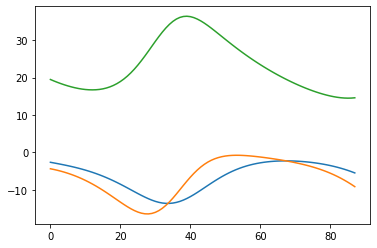

In [49]:
for i in train_dl:
    print(i.shape)
    break
plt.plot(i[0,:,0])
plt.plot(i[0,:,1])
plt.plot(i[0,:,2])
plt.show()

In [50]:
## Create the model
model = TDYANT( Drr, 
                 Dtheta,
                 N,
                 D,
                 hidden_dim,
               latent_dim,
                 dropout,
               layer_norm_epsilon,
                 device).to(device)

model.mu = train_dl.dataset.mu.to(device)
model.std = train_dl.dataset.std.to(device)



In [51]:
model.device = "cuda:0"
model = model.cuda()
device = "cuda:0"

In [52]:
torch.cuda.empty_cache()
start_epoch = 1

optimizer = torch.optim.Adam(model.parameters(), lr=LR*0.995 ** (start_epoch - 1),weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

## If want to continue training from a checkpoint
if(load_ckpt):
    print("LOADING CHECKPT")
    loadedcheckpoint = torch.load(ckpt_file)
    start_epoch = loadedcheckpoint['epoch']
    model.load_state_dict(loadedcheckpoint['state_dict'])
    optimizer.load_state_dict(loadedcheckpoint['optimizer'])

print("Training from epoch: ", start_epoch)
print('-' * 25)


Training from epoch:  1
-------------------------


In [53]:
print_every = 1

In [54]:
## Start the Training
for epoch in range(start_epoch, EPOCH+1):
   
    model.train()
    
    train_epoch_loss = []; test_epoch_loss = []
    train_norm_loss = []; test_norm_loss = []
    train_latent_loss = []; test_latent_loss = [];
    train_reconstruction_loss = []; test_reconstruction_loss = [];
    train_prediction_loss = []; test_prediction_loss = []
    
    start = time.time()
    for x in tqdm(train_dl):
        x = x.to(device)
        optimizer.zero_grad()
        loss,reconstruction_loss,prediction_loss,latent_loss,norm_loss = dynamic_loss(x,model,horizon,alpha=alpha)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        optimizer.step()
        train_epoch_loss.append(loss.item()*x.shape[0])
        train_latent_loss.append(latent_loss.item()*x.shape[0])
        train_norm_loss.append(norm_loss.item()*x.shape[0])
        train_reconstruction_loss.append(reconstruction_loss.item()*x.shape[0])
        train_prediction_loss.append(prediction_loss.item()*x.shape[0])
        end = time.time()
    scheduler.step()
    torch.cuda.empty_cache()
    
    if (epoch)%print_every == 0:
        model.eval()
        with torch.no_grad():
            for x in tqdm(test_evaluator_dl):
                x = x[0].to(device)
#                 x = X_test[:,-72:,:].to(device)
                loss,reconstruction_loss,prediction_loss,latent_loss,norm_loss = dynamic_loss(x,model,horizon,alpha=alpha)
                test_epoch_loss.append(loss.item()*x.shape[0])
                test_latent_loss.append(latent_loss.item()*x.shape[0])
                test_norm_loss.append(norm_loss.item()*x.shape[0])
                test_reconstruction_loss.append(reconstruction_loss.item()*x.shape[0])
                test_prediction_loss.append(prediction_loss.item()*x.shape[0])
                
    print('Epoch: ', epoch)
    print("| train time: %.6f" % (end-start))
    print('| train loss: %.6f' % (np.sum(train_epoch_loss)/N_train))
    print('| train reconstruction loss: %.6f' % (np.sum(train_reconstruction_loss)/N_train))
    print('| train prediction loss: %.6f' % (np.sum(train_prediction_loss)/N_train))
    print('| train LATENT loss: %.6f' % (np.sum(train_latent_loss)/N_train))
    print('| LATENT NORM: %.6f' % (np.sum(train_norm_loss)/N_train))
    if (epoch)%print_every == 0:
        print('| val loss: %.6f' % (np.sum(test_epoch_loss)/N_test))
        print('| val reconstruction loss: %.6f' % (np.sum(test_reconstruction_loss)/N_test))
        print('| val prediction loss: %.6f' % (np.sum(test_prediction_loss)/N_test))
        print('| val LATENT loss: %.6f' % (np.sum(test_latent_loss)/N_test))
        print('| val LATENT NORM: %.6f' % (np.sum(test_norm_loss)/N_test))
    print("\n")

#     print("Classification Report:")
#     print(classification_report(labels,predictions,zero_division=1))
    
    if epoch % saveEvery ==0 :
        print("Saving Checkpoint")
        save_checkpoint({'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer' : optimizer.state_dict(),
                        },f"data/{dataset_name}/"+checkptname+str(epoch)+'.pth')

  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


  1%|█                                                                                  | 1/79 [00:00<00:38,  2.01it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


  3%|██                                                                                 | 2/79 [00:00<00:27,  2.83it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


  4%|███▏                                                                               | 3/79 [00:00<00:23,  3.28it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


  5%|████▏                                                                              | 4/79 [00:01<00:21,  3.56it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


  6%|█████▎                                                                             | 5/79 [00:01<00:19,  3.74it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


  8%|██████▎                                                                            | 6/79 [00:01<00:18,  3.85it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


  9%|███████▎                                                                           | 7/79 [00:01<00:18,  3.93it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


 10%|████████▍                                                                          | 8/79 [00:02<00:18,  3.90it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


 11%|█████████▍                                                                         | 9/79 [00:02<00:17,  3.96it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


 13%|██████████▍                                                                       | 10/79 [00:02<00:17,  3.99it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


 14%|███████████▍                                                                      | 11/79 [00:02<00:16,  4.05it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


 15%|████████████▍                                                                     | 12/79 [00:03<00:16,  4.11it/s]

torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


 16%|█████████████▍                                                                    | 13/79 [00:03<00:18,  3.65it/s]


torch.Size([128, 16, 3])
torch.Size([128, 72, 3])


KeyboardInterrupt: 

In [ ]:
# print("Saving Checkpoint")
# checkptname = "lorenz_prediction_fc_great" #"lorenz_prediction\lorenz_prediction50_best"
# save_checkpoint({'epoch': epoch + 1,
#                 'state_dict': model.state_dict(),
#                 'optimizer' : optimizer.state_dict(),
#                 },f"data/{dataset_name}/"+checkptname+str(epoch)+'.pth')

In [ ]:
## If want to continue training from a checkpoint
ckpt_file = f"data/{dataset_name}/"+checkptname+str(200)+'.pth' # for Kitti Dataset: 'KittiModel.pth'if(True):
print("LOADING CHECKPT")
loadedcheckpoint = torch.load(ckpt_file)
start_epoch = loadedcheckpoint['epoch']
model.load_state_dict(loadedcheckpoint['state_dict'])
optimizer.load_state_dict(loadedcheckpoint['optimizer'])

In [22]:
with torch.no_grad():
    model.eval()
    train_epoch_loss = []; test_epoch_loss = []
    train_norm_loss = []; test_norm_loss = []
    train_latent_loss = []; test_latent_loss = [];
    train_reconstruction_loss = []; test_reconstruction_loss = [];
    train_prediction_loss = []; test_prediction_loss = []
    for x in tqdm(test_evaluator_dl):
        x = x[0].to(device)
        loss,reconstruction_loss,prediction_loss,latent_loss,norm_loss = dynamic_loss(x,model,horizon,alpha=alpha)
        test_epoch_loss.append(loss.item()*x.shape[0])
        test_latent_loss.append(latent_loss.item()*x.shape[0])
        test_norm_loss.append(norm_loss.item()*x.shape[0])
        test_reconstruction_loss.append(reconstruction_loss.item()*x.shape[0])
        test_prediction_loss.append(prediction_loss.item()*x.shape[0])
print('| val loss: %.6f' % (np.sum(test_epoch_loss)/N_test))
print('| val reconstruction loss: %.6f' % (np.sum(test_reconstruction_loss)/N_test))
print('| val prediction loss: %.6f' % (np.sum(test_prediction_loss)/N_test))
print('| val LATENT loss: %.6f' % (np.sum(test_latent_loss)/N_test))
print('| val LATENT NORM: %.6f' % (np.sum(test_norm_loss)/N_test))

 50%|██████████████████████████████████████████                                          | 4/8 [00:03<00:03,  1.30it/s]


KeyboardInterrupt: 

In [24]:
with torch.no_grad():
    model.eval()
    loss,reconstruction_loss,prediction_loss,latent_loss,norm_loss = dynamic_loss(X_test[:,-Time_Length:,:].to(device),model,horizon,alpha=alpha)
    print('| val loss: %.6f' % (loss))
    print('| val reconstruction loss: %.6f' % (reconstruction_loss))
    print('| val prediction loss: %.6f' % (prediction_loss))
    print('| val LATENT loss: %.6f' % (latent_loss))
    print('| val LATENT NORM: %.6f' % (norm_loss))

| val loss: 0.762352
| val reconstruction loss: 0.069184
| val prediction loss: 0.231056
| val LATENT loss: 0.000153
| val LATENT NORM: 11.275913


In [29]:
x.shape

torch.Size([1000, 88, 3])

In [36]:
with torch.no_grad():
    x = X_test[:,100:(100+Time_Length),:]
    model.eval()
    x_recon_hat,x_ahead_hat,latent,y_recon,y_ahead = model(x.to(device),horizon)
    loss = F.mse_loss(x_ahead_hat,x[:,-72:,:].to(device))
    print('| val prediction loss: %.6f' % loss)

| val prediction loss: 0.244869


In [ ]:
model = model.to("cuda:0")
model.device = "cuda:0"

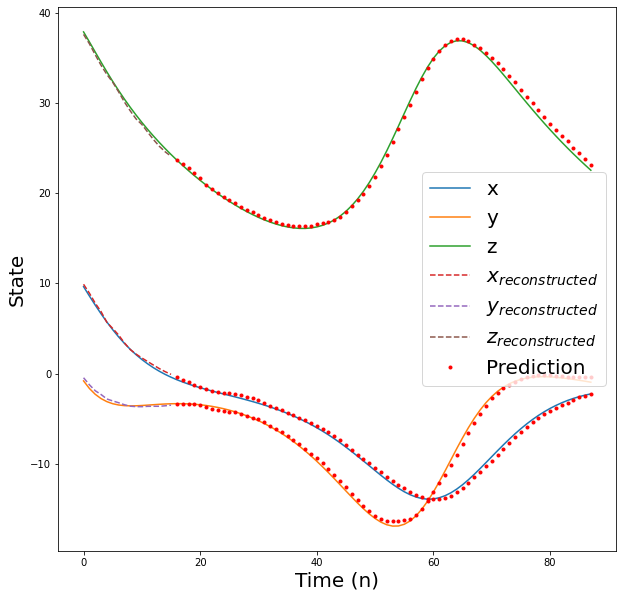

In [37]:
n = 5
x = X_test[[n],-Time_Length:,:]
model.eval()
with torch.no_grad():
    x_recon_hat,x_ahead_hat,latent,y_recon,y_ahead = model(x.to(device),horizon)

    plt.figure(figsize=(10,10))
#     for i in range(3):
    plt.plot(np.arange(Time_Length),x[0])
    plt.plot(np.arange(horizon),x_recon_hat[0,:,:].cpu(),'--')
    plt.plot(horizon+np.arange(Time_Length-horizon),x_ahead_hat[0,:,:].cpu(),'r.')

    plt.xlabel("Time (n)",fontsize=20)
    plt.ylabel("State",fontsize=20)
    plt.legend(["x","y","z","$x_{reconstructed}$","$y_{reconstructed}$","$z_{reconstructed}$","Prediction"],fontsize=20)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(x[0,:,0],x[0,:,1],'k')
plt.plot(x_recon_hat[0,:,0].cpu(),x_recon_hat[0,:,1].cpu(),'b*')
plt.plot(x_ahead_hat[0,:,0].cpu(),x_ahead_hat[0,:,1].cpu(),'r*')

In [42]:
with torch.no_grad():
    nrow = 8; ncol = 16
    fig, axs = plt.subplots(nrow, ncol)
    if nrow == 1:
        axs = np.expand_dims(axs,0)
    for i in range(nrow):
        for j in range(ncol):
            axs[i,j].plot(latent[0,:,i*ncol + j].cpu().detach().numpy())
            axs[i,j].plot(y_recon[0,:,i*ncol + j].cpu().detach().numpy())
            axs[i,j].title.set_text(f"Feature {i*ncol+j+1}")

C:\Users\lpott\anaconda3\envs\DYAN\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
C:\Users\lpott\anaconda3\envs\DYAN\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


In [ ]:
with torch.no_grad():
    nrow = 8; ncol = 8
    fig, axs = plt.subplots(nrow, ncol)
    if nrow == 1:
        axs = np.expand_dims(axs,0)
    for i in range(nrow):
        for j in range(ncol):
            axs[i,j].plot(y_ahead[0,:,i*ncol + j].cpu().detach().numpy())
            axs[i,j].title.set_text(f"Feature {i*ncol+j+1}")

In [ ]:
128/8

In [41]:
with torch.no_grad():
    nrow = 8; ncol = 16
    fig, axs = plt.subplots(nrow, ncol)
    if nrow == 1:
        axs = np.expand_dims(axs,0)
    for i in range(nrow):
        for j in range(ncol):
            axs[i,j].plot(torch.concat((y_recon[0,:,i*ncol + j],y_ahead[0,:,i*ncol + j])).cpu().detach().numpy())
            axs[i,j].title.set_text(f"Feature {i*ncol+j+1}")
            axs[i,j].title.set_fontsize(30)

In [ ]:
plt.figure()
%matplotlib qt5
ax = plt.axes(projection='3d')
ax.plot3D(x[0,:,0],x[0,:,1],x[0,:,2],'k-') #c=np.linspace(0,1,Time_Length))
ax.set_xlabel('$X$', fontsize=20)
ax.set_ylabel('$Y$',fontsize=20)
ax.set_zlabel(r'$Z$', fontsize=20)

In [40]:
plt.figure()
%matplotlib qt5
ax = plt.axes(projection='3d')
ax.plot3D(x[0,:,0].cpu(),x[0,:,1].cpu(),x[0,:,2].cpu(),'k-') #c=np.linspace(0,1,Time_Length))
ax.plot3D(x_recon_hat[0,:,0].cpu(),x_recon_hat[0,:,1].cpu(),x_recon_hat[0,:,2].cpu(),'b*')
ax.plot3D(x_ahead_hat[0,:,0].cpu(),x_ahead_hat[0,:,1].cpu(),x_ahead_hat[0,:,2].cpu(),'rx')
ax.set_xlabel('$X$', fontsize=20)
ax.set_ylabel('$Y$',fontsize=20)
ax.set_zlabel(r'$Z$', fontsize=20)
plt.legend(["Actual","Reconstruction","Prediction"])
plt.show()

C:\Users\lpott\anaconda3\envs\DYAN\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
C:\Users\lpott\anaconda3\envs\DYAN\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


In [39]:
# plt.figure()
%matplotlib qt5
ax = plt.axes(projection='3d')
ax.scatter3D(x[n,horizon:,0],x[n,horizon:,1],x[n,horizon:,2],c=np.linspace(0,1,Time_Length-horizon))
ax.scatter3D(x_ahead_hat[n,:,0].cpu(),x_ahead_hat[n,:,1].cpu(),x_ahead_hat[n,:,2].cpu())
ax.set_xlabel('$X$', fontsize=20)
ax.set_ylabel('$Y$',fontsize=20)
ax.set_zlabel(r'$Z$', fontsize=20)
plt.show()

IndexError: index 5 is out of bounds for dimension 0 with size 1

In [ ]:
X = np.array([[0.778,0.770,0.756,0.732,0.722,0.756,0.717],
[0.689,0.683, 0.647, 0.633, 0.577, 0.528 ,0.529],
[0.993,0.992,0.712, 0.696, 0.319, 0.956, 0.963],
[0.851,0.825,0.751 ,0.983 ,0.399, 0.688, 0.711]])

In [ ]:
import pandas as pd

In [ ]:
ranks = pd.DataFrame(X).rank(axis=1,ascending=False)

In [ ]:
ranks

In [ ]:
ranks

In [ ]:
ranks.mean(0)